 ## Notebook to test the impact of variable pixel size on cube building ##

In [3]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.io import fits
#import miri3d.miri3d.modshep.modshep as ms

In [4]:
# Flag whether input units are flux or surface brightness
inpunits='sb'

In [51]:
# Function to make an image
def makeim(x,y,f,dim_out,expsig,rlim,scale):
    fim=np.zeros(dim_out)
    arr_xcoord = np.arange(dim_out[0])
    arr_ycoord = np.arange(dim_out[1])
    ntot=len(f)
    for j in range(dim_out[1]):
                # trim to only stuff within rlim of this y location
                indexj=np.where(abs(y-arr_ycoord[j]) <= rlim)
                nindexj = len(indexj[0])
                # build the row
                if (nindexj > 0):
                    tempx2=x[indexj]
                    tempy2=y[indexj]
                    tempf2=f[indexj]

                    # Now do a 1d build within this slice, looping over input points
                    arr_weights=np.zeros((nindexj,dim_out[0]))

                    for q in range(nindexj):
                        # Don't calculate full radii for everything; if x component is too big
                        # then radius guaranteed too big.  Set default radius slightly larger than
                        # desired selection radius.  This saves a bunch of compute time.
                        arr_radius=(rlim+1)*np.ones(dim_out[0])
                        arr_sradius=(rlim+1)*np.ones(dim_out[0])

                        # Which output pixels are affected by input points, i.e.
                        # within rlim of this x location?
                        # Don't go outside output array boundaries
                        xmin=max(np.floor(tempx2[q]-rlim).astype(int),0)
                        # Note python needs xmax 1 greater than if this was IDL...
                        xmax=min(np.ceil(tempx2[q]+rlim).astype(int), dim_out[0]-1)+1
                        # Number of points within box
                        nbox=xmax-xmin

                        # Calculate physical spatial radius for ROI determination
                        rx=arr_xcoord[xmin:xmax]-tempx2[q]
                        ry=arr_ycoord[j]-tempy2[q]
                        arr_radius[xmin:xmax]=np.sqrt(rx**2 + np.ones(nbox)*ry**2)

                        # Determine points within the final circular ROI
                        tocalc=np.where(arr_radius <= rlim)
                        ncalc = len(tocalc[0])

                        # Combine normalized radii inside ROI
                        arr_sradius[xmin:xmax] = np.sqrt( (rx**2) + np.ones(nbox)* ry**2)

                        # Ensure no divide by zero
                        if (ncalc > 0):
                            arr_weights[q,tocalc]=np.exp(-0.5/expsig**2*arr_sradius[tocalc]**2)
                                
                    # Normalization matrix
                    if (nindexj == 1):
                        matr_norm=arr_weights.reshape(-1)
                    else:
                        matr_norm = np.sum(arr_weights,0)

                    # Flag where the normalization matrix is zero; there is no good datum here
                    nodata=np.where(matr_norm == 0)
                    nnodata = len(nodata[0])
                    gooddata = np.where(matr_norm != 0)
                    ngood = len(gooddata[0])

                    # We don't want to divide by zero where there is no data# set the normalization
                    # matrix to 1 in these cases
                    if (nnodata > 0):
                        matr_norm[nodata]=1.

                    # Apply the weights to calculate the output flux in this row
                    frow=np.zeros(dim_out[0])

                    for q in range (nindexj):
                        alpha=arr_weights[q,:]/matr_norm
                        frow+=tempf2[q]*alpha

                    # Put the row into the final cube
                    fim[:,j]=frow*scale
    return fim

In [6]:
# Set up the master scene
scene_xsize,scene_ysize=10,10 # Arcsec
scene_dx,scene_dy=0.001,0.001
scene_nx,scene_ny=int(scene_xsize/scene_dx),int(scene_ysize/scene_dy)
# Scene coordinates in 1d
scenex,sceney = np.meshgrid(np.arange(scene_ny),np.arange(scene_nx))
scenex=scenex.reshape(-1)
sceney=sceney.reshape(-1)
# Put a point source in the middle
scene=np.zeros([scene_ny,scene_nx])
xcen=int(scene_nx/2)
ycen=int(scene_ny/2)
scenetot=1.0
scene[xcen,ycen]=scenetot
# Convolve with 0.3'' FWHM PSF
fwhm_input=0.3 # arcsec
scene=ndimage.gaussian_filter(scene,fwhm_input/scene_dx/2.35)

(3000, 7000)

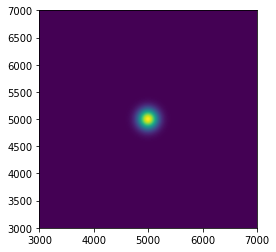

In [8]:
norm = colors.LogNorm(scene.mean() + 0.5 * scene.std(), scene.max(), clip='True')
plt.imshow(scene,origin="lower")
plt.xlim(3000,7000)
plt.ylim(3000,7000)

In [9]:
hdu=fits.PrimaryHDU(scene)
hdu.writeto('scene.fits',overwrite=True)

In [225]:
# Set up our grid of spaxels that will match pixel boundaries in the scene perfectly
slicew=0.2 # This sets the slicewidth in arcsec, taken to be constant
slice_ny=slicew/scene_dy
# Number of slices
nslice=14
# Number of pixels per slice
npix=12
# Make a slice mask
smask=scene.copy()
smask[:,:]=0        

In [226]:
# How many discrete samples?
nspax=nslice*npix
spaxid=np.zeros(nspax).astype(int)
# X locations of sample
spax_x,spax_y=np.zeros(nspax),np.zeros(nspax)
# Integrated flux of sample
spax_f=np.zeros(nspax)
# Spaxel area in arcsec2
spax_area=np.zeros(nspax)
# Spaxel surface brightness
spax_sb=np.zeros(nspax)

In [231]:
testshift=np.arange(-2,2,0.2)
nshift=len(testshift)
testscale=np.arange(0.8,1.2,0.02)
nscl=len(testscale)
norm1=np.zeros([nshift,nscl])
norm2=np.zeros([nshift,nscl])
for yy in range(0,nshift):
    for zz in range(0,nscl):
        smask[:,:]=0  
        ybaseshift=testshift[yy]*slice_ny
        xbaseshift=0.1/scene_dx
        for ii in range(0,nslice):
            ylo=int((scene_ny/2)+(ii-nslice/2)*slice_ny-slice_ny/2+ybaseshift)
            yhi=int(ylo+slice_ny)
            # Pixel slice width changes by +-1% per row
            #pixw=slicew+slicew*0.03*(ii-nslice/2)
            #pixw=slicew*0.86
            if (ii%2 == 0):
                pixw=slicew
            else:
                pixw=slicew*testscale[zz]
            pixw_nx=int(pixw/scene_dx)
            #print(pixw_nx)
            for jj in range(0,npix):
                xlo=int((scene_nx/2)+(jj-npix/2)*pixw_nx-pixw_nx/2+xbaseshift)
                xhi=int(xlo+pixw_nx)
                smask[ylo:yhi,xlo:xhi]=ii*npix+jj
                spaxid[ii*npix+jj]=int(ii*npix+jj)
                spax_x[ii*npix+jj]=(xlo+xhi)/2.
                spax_y[ii*npix+jj]=(ylo+yhi)/2.
                spax_f[ii*npix+jj]=np.sum(scene[ylo:yhi,xlo:xhi])
                spax_area[ii*npix+jj]=(xhi-xlo)*(yhi-ylo)*scene_dx*scene_dy
                spax_sb[ii*npix+jj]=spax_f[ii*npix+jj]/spax_area[ii*npix+jj]
        
        # Output uses 0.1'' spaxels
        os=0.1
        xout=spax_x*scene_dx/os
        yout=spax_y*scene_dy/os
        dim_out=[int(scene_ysize/os),int(scene_xsize/os)]
        rlim=0.4/os
        expsig=0.1/os
        scale=os*os
        recim=makeim(xout,yout,spax_sb,dim_out,expsig,rlim,scale)
        recim2=makeim(xout,yout,spax_f,dim_out,expsig,rlim,1.0)
        norm1[yy,zz]=np.sum(recim)
        norm2[yy,zz]=np.sum(recim2)

In [232]:
norm1.shape

(20, 20)

Text(0.5,1,'SB cubes')

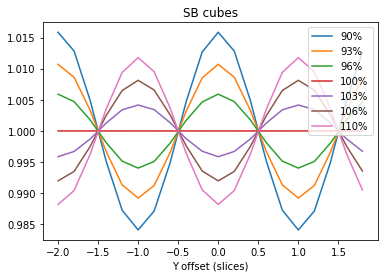

In [253]:
plt.plot(testshift,norm1[:,0]/np.median(norm1),label='90%')
plt.plot(testshift,norm1[:,3]/np.median(norm1),label='93%')
plt.plot(testshift,norm1[:,6]/np.median(norm1),label='96%')
plt.plot(testshift,norm1[:,10]/np.median(norm1),label='100%')
plt.plot(testshift,norm1[:,13]/np.median(norm1),label='103%')
plt.plot(testshift,norm1[:,16]/np.median(norm1),label='106%')
plt.plot(testshift,norm1[:,19]/np.median(norm1),label='110%')
plt.legend()
plt.xlabel('Y offset (slices)')
plt.title('SB cubes')
#plt.ylim(0.88,1.12)

Text(0.5,1,'Flux cubes')

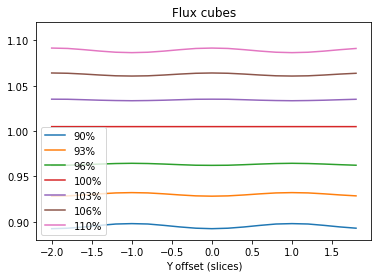

In [250]:
plt.plot(testshift,norm2[:,0]/np.median(norm2),label='90%')
plt.plot(testshift,norm2[:,3]/np.median(norm2),label='93%')
plt.plot(testshift,norm2[:,6]/np.median(norm2),label='96%')
plt.plot(testshift,norm2[:,10]/np.median(norm2),label='100%')
plt.plot(testshift,norm2[:,13]/np.median(norm2),label='103%')
plt.plot(testshift,norm2[:,16]/np.median(norm2),label='106%')
plt.plot(testshift,norm2[:,19]/np.median(norm2),label='110%')
plt.legend()
plt.xlabel('Y offset (slices)')
plt.ylim(0.88,1.12)
plt.title('Flux cubes')

(3000, 7000)

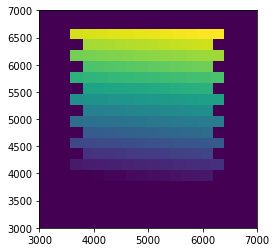

In [254]:
plt.imshow(smask,origin="lower")
plt.xlim(3000,7000)
plt.ylim(3000,7000)

(30, 70)

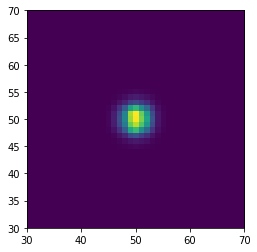

In [252]:
plt.imshow(recim)
plt.xlim(30,70)
plt.ylim(30,70)

(0.9998058268235096, 3.7595346669783667)

In [ ]:
# Now test an input image